# Re-estimation of a transition matrix

In [33]:
import numpy as np
import scipy
import pyemma
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

## Generate discrete trajectory from transition matrix

In [34]:
P = np.matrix([[ 0.97, 0.03, 0],[0.015 , 0.97, 0.015],[ 0, 0.03, 0.97]])

In [35]:
import random
import numpy as np

size = 100000

T = np.matrix([[ 0.97, 0.03, 0],[0.015 , 0.97, 0.015],[ 0, 0.03, 0.97]])
#print(T)

def state0(i,num):
    if num>T[0,0]:
        return i+1
    return i

def state1(i,num):
    if num<T[1,0]:
        return i-1
    elif T[1,0]<num<(T[1,2]+T[1,0]):
        return i+1
    return i

def state2(i,num):
    if num>T[2,2]:
        return i-1
    return i

def decider(i, num):
    new_i = i
    if i==0:
        new_i = state0(i,num)
    if i==1:
        new_i = state1(i,num)
    if i==2:
        new_i = state2(i,num)

    return new_i


i=0 # initial condition
k=0

dtraj=[]
while k<size:
    num = random.uniform(0, 1)
    i = decider(i, num)
    dtraj.append(i)
    k=k+1


## Generate continuous trajectory from discrete trajectory

In [36]:
# parameters

mu_0 = [2,0]
mu_1 = [0,0]
mu_2 = [-2,0]

y_noise = 10
x_noise = 0.1

sigma_0 = [[x_noise,0],[0,y_noise]]
sigma_1 = [[x_noise,0],[0,y_noise]]
sigma_2 = [[x_noise,0],[0,y_noise]]

mus = [mu_0, mu_1, mu_2]
sigmas = [sigma_0, sigma_1, sigma_2]

# generates a continuous trajectory drawn from bivariate gaussians
def generate_traj(dtraj, mus, sigmas):
    traj = []
    for i in range(len(dtraj)):
        if dtraj[i] == 0:
            traj.append(np.random.multivariate_normal(mus[0], sigmas[0], size=1)[0])
        elif dtraj[i] == 1:
            traj.append(np.random.multivariate_normal(mus[1], sigmas[1], size=1)[0])
        elif dtraj[i] == 2:
            traj.append(np.random.multivariate_normal(mus[2], sigmas[2], size=1)[0])
        else:
            print("something went wrong")
            exit()
    return np.array(traj)

traj = generate_traj(dtraj, mus, sigmas)

#print(traj)

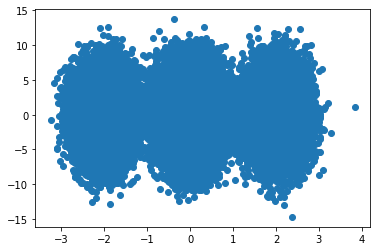

In [37]:
traj.shape

plt.scatter(*traj.T)
plt.show()

## Rotate trajectory into 5 dimensions and add noise

In [38]:
def random_matrix():
    v=np.array([np.random.random() for n in range(5)])
    w=np.array([np.random.random() for n in range(5)])
    #generating two random 5d vectors
    vn=v/np.sqrt(sum(v**2))
    wn=(w-np.dot(w,vn)*vn)/np.sqrt(sum((w-np.dot(w,vn)*vn)**2))
    #orthonormalization with Gram-Schmidt
    
    return np.array([vn,wn])

def fived(x,y, random_matrix,noise):
    noise_matrix=[[np.random.random() - 0.5 for n in range(5)],[np.random.normal() for n in range(5)],[np.random.poisson() for n in range(5)]]
    out=np.matmul(np.array([x,y]), random_matrix) + 0.2 * np.array(noise_matrix[noise])
    return out

random_matrix = random_matrix()

In [39]:
traj_5dim = []

for i in range(len(traj)):
    traj_5dim.append(fived(traj[i,0],traj[i,1], random_matrix, 1))

traj_5dim = np.array(traj_5dim)

## Analyse generated trajectory with pyEMMA

In [40]:
#specify data
data = traj_5dim

tica = pyemma.coordinates.tica(data, lag=10, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

cls_tica = pyemma.coordinates.cluster_kmeans(tica, k=3, max_iter=50, stride=10)
its_tica = pyemma.msm.its(cls_tica.dtrajs, lags=[1, 2, 5, 10, 20], nits=2, errors='bayes')

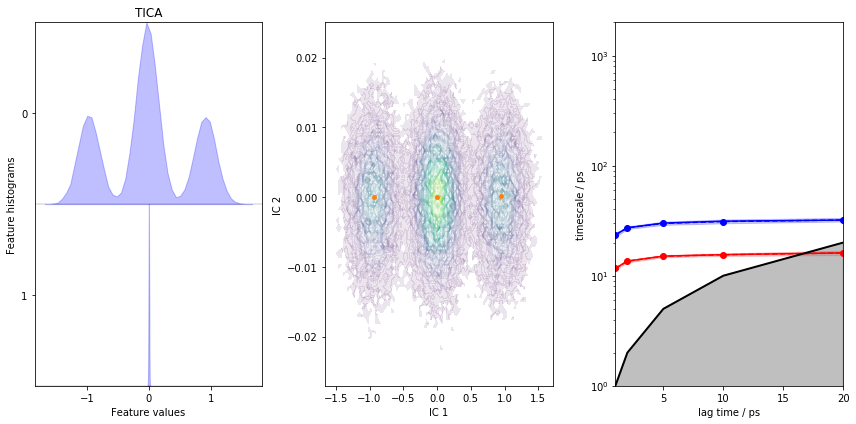

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0])
axes[0].set_title('TICA')
pyemma.plots.plot_density(*tica_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)

axes[1].scatter(*cls_tica.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its_tica, ax=axes[2], units='ps')
axes[2].set_ylim(1, 2000)
axes[2].set_ylim(1, 2000)
fig.tight_layout()

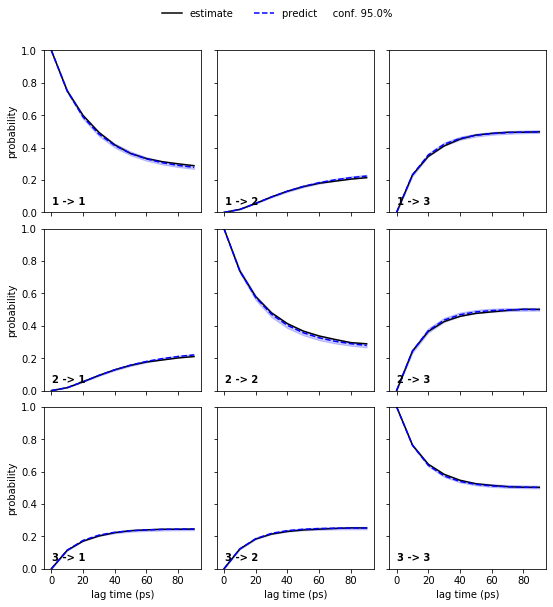

In [42]:
# generate msm
bayesian_msm = pyemma.msm.bayesian_markov_model(cls_tica.dtrajs, lag=10, dt_traj='1 ps')
# plot ck test
pyemma.plots.plot_cktest(bayesian_msm.cktest(3), units='ps');

In [43]:
# transition matrix
T = scipy.linalg.fractional_matrix_power(bayesian_msm.transition_matrix, 1/10)
print(bayesian_msm.transition_matrix)
print()
print(T)

print(bayesian_msm.score(cls_tica.dtrajs))

[[0.7500909  0.01843625 0.23147284]
 [0.0181088  0.73831181 0.24357939]
 [0.11429678 0.12244966 0.76325357]]

[[0.96956636 0.00017081 0.03026283]
 [0.00016778 0.96770971 0.03212252]
 [0.0149432  0.01614829 0.96890851]]
21-02-20 10:27:37 pyemma.msm.estimators.bayesian_msm.BayesianMSM[40] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 3
1.8036527205054174


In [44]:
#specify data
data = traj_5dim

pca = pyemma.coordinates.pca(data, dim=2)
pca_concatenated = np.concatenate(pca.get_output())

cls_pca = pyemma.coordinates.cluster_kmeans(pca, k=3, max_iter=50, stride=10)
its_pca = pyemma.msm.its(cls_pca.dtrajs, lags=[1, 2, 5, 10, 20], nits=2, errors='bayes')

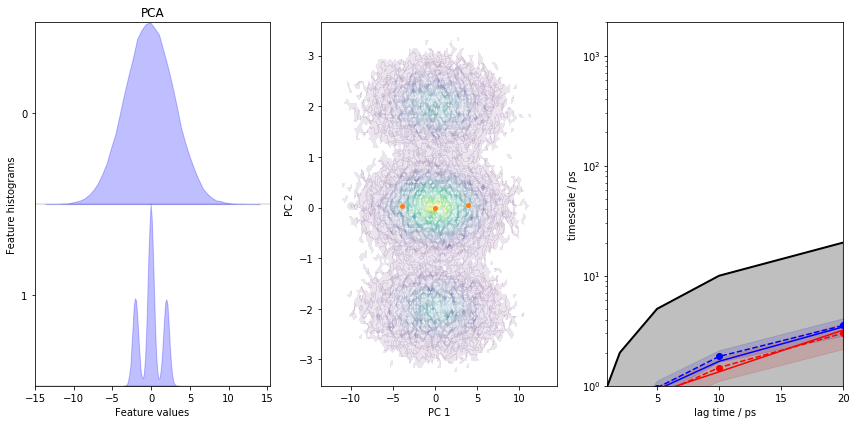

In [45]:
#plt.hist(pca_concatenated, bins=100);

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
pyemma.plots.plot_feature_histograms(pca_concatenated, ax=axes[0])
axes[0].set_title('PCA')
pyemma.plots.plot_density(*pca_concatenated.T, ax=axes[1], cbar=False, alpha=0.1)

axes[1].scatter(*cls_pca.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
pyemma.plots.plot_implied_timescales(its_pca, ax=axes[2], units='ps')
axes[2].set_ylim(1, 2000)
axes[2].set_ylim(1, 2000)
fig.tight_layout()

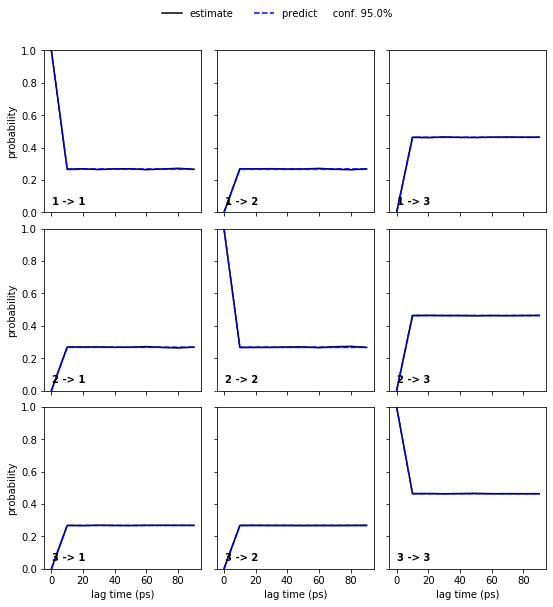

In [46]:
# generate msm
bayesian_msm = pyemma.msm.bayesian_markov_model(cls_pca.dtrajs, lag=10, dt_traj='1 ps')
# plot ck test
pyemma.plots.plot_cktest(bayesian_msm.cktest(3), units='ps');

In [47]:
# transition matrix
T = scipy.linalg.fractional_matrix_power(bayesian_msm.transition_matrix, 1/10)
print(bayesian_msm.transition_matrix)
print()
print(T)
print()

print(bayesian_msm.score(cls_pca.dtrajs))

[[0.26679606 0.46363327 0.26957067]
 [0.26789291 0.46412092 0.26798617]
 [0.26938073 0.46346789 0.26715138]]

[[0.64057169+0.089406j   0.2425336 -0.00467941j 0.1168947 -0.08472659j]
 [0.14013885-0.00270382j 0.71812423+0.00014151j 0.14173693+0.00256231j]
 [0.11681234-0.08466689j 0.24512651+0.00443137j 0.63806115+0.08023552j]]

21-02-20 10:28:00 pyemma.msm.estimators.bayesian_msm.BayesianMSM[48] WARNING  Requested scoring rank 10 exceeds number of MSM states. Reduced to score_k = 3
1.0000180641807455


(<Figure size 864x864 with 1 Axes>, array([[ 1.5,  1.5],
        [ 0. ,  0. ],
        [-1.5, -1.5]]))

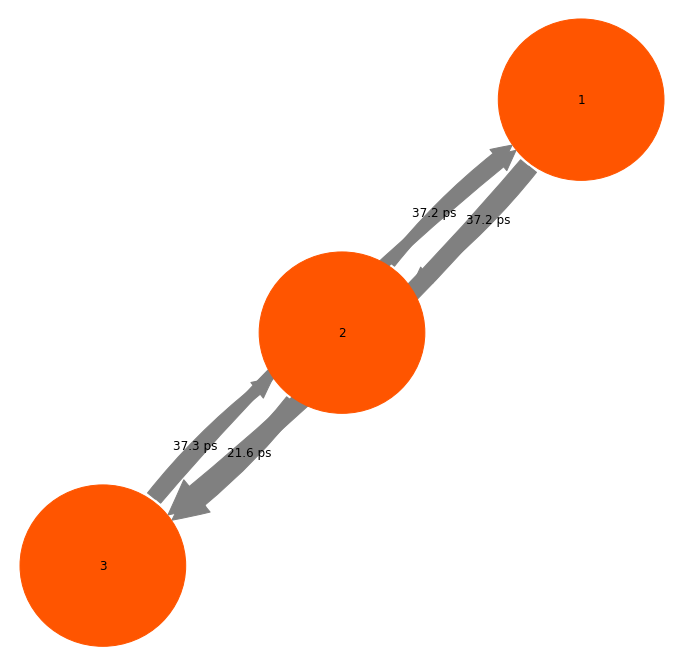

In [48]:
nstates = 3

mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_msm.mfpt(bayesian_msm.metastable_sets[i], bayesian_msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=np.asarray([[1.5, 1.5], [0, 0], [-1.5, -1.5]]),
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    arrow_scale=3.0,
    state_labels=range(1, nstates + 1),
    size=12)